In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm 

from traffic.core import Traffic

/tmp/ipykernel_34531/251887701.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


- Configuration est :  atterrissages 06 / décollages 07 -> A privilégier pour voir des interactions nb: 7818/7616
- Configuration ouest : atterrissages 25 / décollages 24 nb : 9346/9250

# Landings on Runway 06 FAF D8.4 ORE

In [ ]:
t1 = Traffic.from_file("../deep_traffic_generation/data/landings/LFPO_dataset.parquet.gz")

: 

In [3]:
ld_LFPO = list()

for f in tqdm(t1):
    if landings := f.aligned_on_ils("LFPO").next():
        ld_LFPO.append(
            {
                "callsign": f.callsign,
                "icao24": f.icao24,
                "flight_id": f.flight_id,
                "airport": "LFPO",
                "stop": landings.stop,
                "ILS": landings.ILS_max, #shortcut
            })

landings_LFPO = pd.DataFrame.from_records(ld_LFPO)

  0%|          | 0/17348 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [73]:
landings_LFPO.ILS.value_counts()

25    9346
06    7818
24     102
07      47
02      33
20       1
Name: ILS, dtype: int64

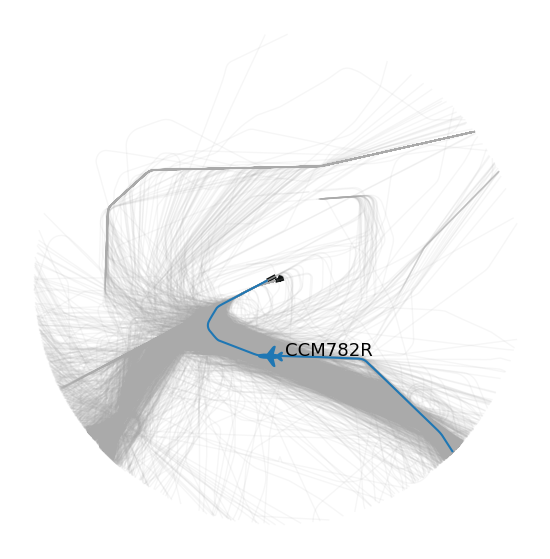

: 

In [ ]:
from traffic.core.projection import Lambert93
from traffic.data import airports
from traffic.data import navaids

with plt.style.context("traffic"):
    fig, ax = plt.subplots(subplot_kw=dict(projection=Lambert93()))

    idx = landings_LFPO.query("ILS == '06'").flight_id.tolist()

    t1[idx].plot(ax, alpha=0.1)

    k = 4000
    t1[k].plot(ax, color="#1f77b4", lw=1.5)
    t1[k].at_ratio(0.5).plot(
        ax,
        color="#1f77b4",
        zorder=3,
    )

    airports["LFPO"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)

plt.show()

Output()

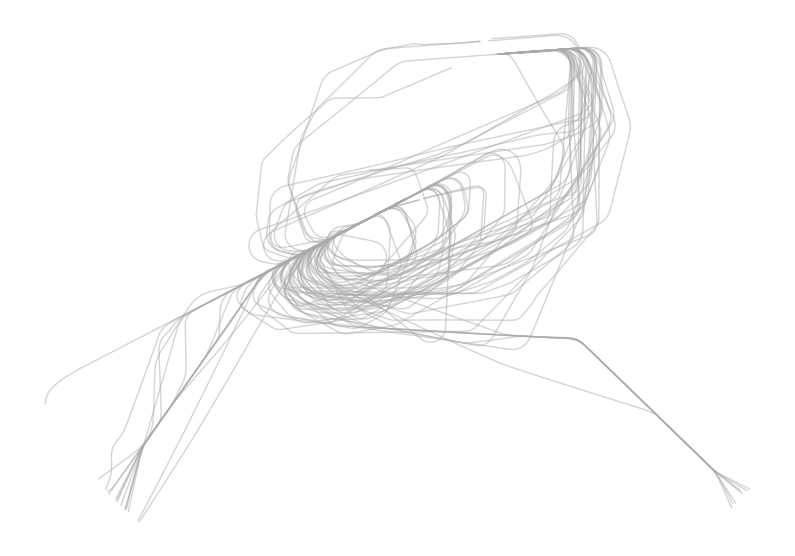

In [89]:
#Identify trajectories that have an ascent phase
t_ld = t1[idx]
t_ld_phases = t_ld.iterate_lazy().phases().eval(desc = "", max_workers = 20)
id_climb = t_ld_phases.query("phase ==  'CLIMB'").flight_ids

with plt.style.context("traffic"):
    ax = plt.axes(projection=Lambert93())
    t_ld[id_climb].plot(ax, alpha=0.5)
plt.show()

t_ld = t_ld.query(
    f"flight_id not in {id_climb}"
)

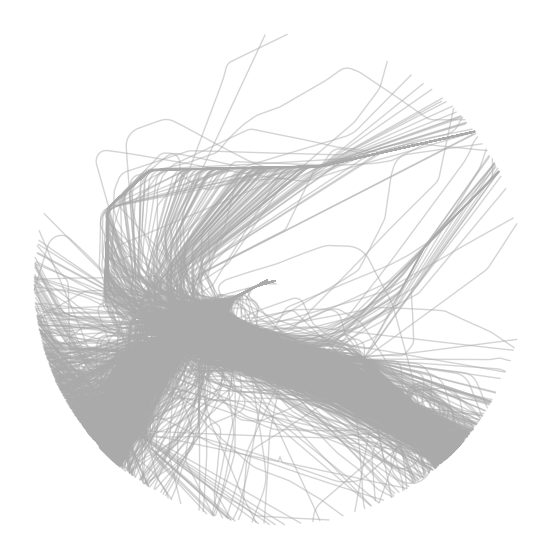

In [90]:
with plt.style.context("traffic"):
    ax = plt.axes(projection=Lambert93())
    t_ld.plot(ax, alpha=0.5)
plt.show()

In [91]:
#Cut every trajectories 3NM before runway threshold

from traffic.core.mixins import PointMixin

thres_06 = PointMixin()
thres_06.latitude, thres_06.longitude =  (airports["LFPO"].runways.data.query("name == '06'").latitude.values[0], airports["LFPO"].runways.data.query("name == '06'").longitude.values[0])


def til_thres(flight):
    g = flight.query("distance > 1*1.852")
    if g is None:
        return None
    return flight.before(g.stop)


t_ld = t_ld.distance(thres_06).pipe(til_thres).eval()

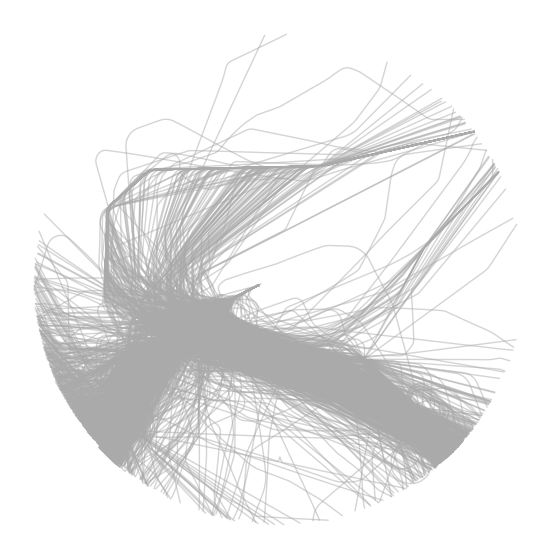

In [92]:
with plt.style.context("traffic"):
    ax = plt.axes(projection=Lambert93())
    t_ld.plot(ax, alpha=0.5)
plt.show()

In [93]:
t_ld = t_ld.iterate_lazy().resample(200).eval(desc = "", max_workers = 20)
t_ld.to_parquet("../deep_traffic_generation/data/training_datasets/landings_06.parquet.gz")

Output()

# Takeoffs

In [2]:
t2 = Traffic.from_file("../deep_traffic_generation/data/takeoffs/LFPO_dataset.parquet.gz")

In [3]:
t2

,count
flight_id,
CALIBRA_9925,6641
CALIBRA_9927,5408
CALIBRA_9926,5343
TVF25JY_7207,1678
CALIBRA_9929,1325
TVF7034_12094,1299
TVF75QQ_8027,1259
DAH1007_1056,1045
DLH05M_1321,889


In [4]:
to_LFPO = list()

for f in tqdm(t2):
    if takeoff := f.takeoff_from_runway("LFPO").next():
        to_LFPO.append(
            {
                "callsign": f.callsign,
                "icao24": f.icao24,
                "flight_id": f.flight_id,
                "airport": "LFPO",
                "start": takeoff.start,
                "RWY": takeoff.runway_max, #shortcut
            })

takeoffs_LFPO = pd.DataFrame.from_records(to_LFPO)

  0%|          | 0/17109 [00:00<?, ?it/s]

In [9]:
takeoffs_LFPO.RWY.value_counts()

24    9250
07    7616
06     153
25      50
20       3
02       2
Name: RWY, dtype: int64

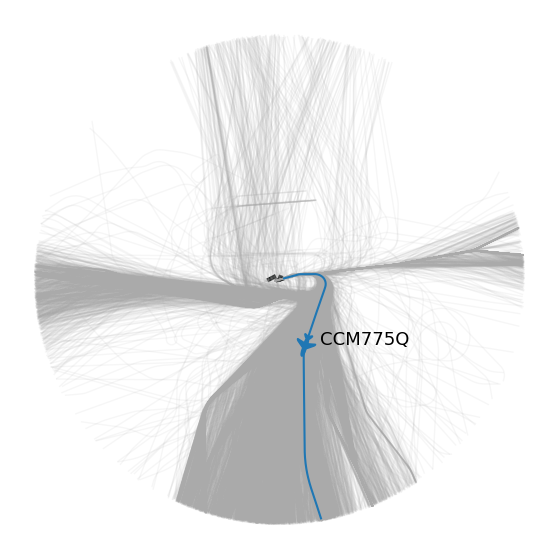

In [5]:
from traffic.core.projection import Lambert93
from traffic.data import airports
from traffic.data import navaids

with plt.style.context("traffic"):
    fig, ax = plt.subplots(subplot_kw=dict(projection=Lambert93()))

    idx = takeoffs_LFPO.query("RWY == '07'").flight_id.tolist()

    t2[idx].plot(ax, alpha=0.1)

    k = 4000
    t2[k].plot(ax, color="#1f77b4", lw=1.5)
    t2[k].at_ratio(0.5).plot(
        ax,
        color="#1f77b4",
        zorder=3,
    )

    airports["LFPO"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)

plt.show()

In [8]:
#Takeoff in 07. So we cut every trajectory 1NM after the end of runway (ie the threshold of runway 25)

from traffic.core.mixins import PointMixin

thres_25 = PointMixin()
thres_25.latitude, thres_25.longitude =  (airports["LFPO"].runways.data.query("name == '25'").latitude.values[0], airports["LFPO"].runways.data.query("name == '25'").longitude.values[0])


def til_thres(flight):
    g = flight.query("distance > 1*1.852")
    if g is None:
        return None
    return flight.after(g.start)


t_to = t2[idx].distance(thres_25).pipe(til_thres).eval(desc = "")

Output()

Output()

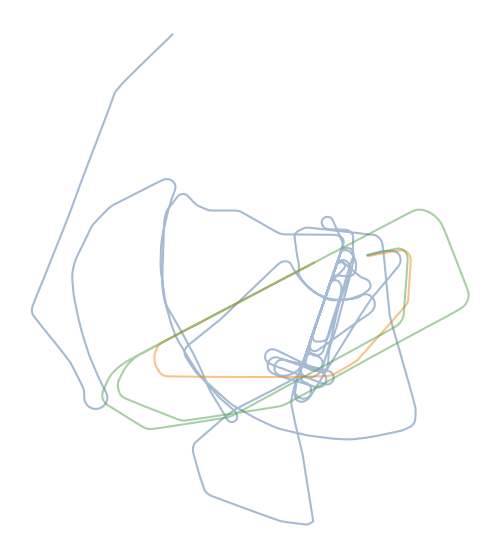

In [33]:
#suppress aircrafts that land back in LFPO
ld = t_to.iterate_lazy().has(f"aligned_on_LFPO").eval(desc = "", max_workers = 20)
t_to = t_to.query(
    f"flight_id not in {ld.flight_ids}"
)

with plt.style.context("traffic"):
    ax = plt.axes(projection=Lambert93())
    ld.plot(ax, alpha=0.5)
plt.show()

Output()

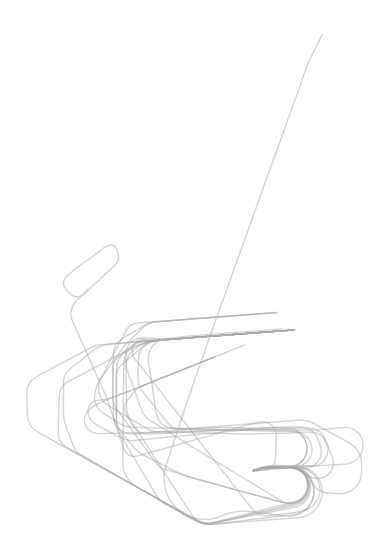

In [48]:
#Identify trajectories that land on an other airport (mostly le Bourget)
t_to_phases = t_to.iterate_lazy().phases().eval(desc = "", max_workers = 20)
id_descent = t_to_phases.query("phase ==  'DESCENT'").flight_ids

with plt.style.context("traffic"):
    ax = plt.axes(projection=Lambert93())
    t_to[id_descent].plot(ax, alpha=0.5)
plt.show()

t_to = t_to.query(
    f"flight_id not in {id_descent}"
)

In [51]:
t_to

,count
flight_id,
DAH1007_1056,1008
AFR72KT_6220,600
TVF76FC_7749,530
AFR67BY_9770,508
TAP449X_16647,500
VLG8570_3575,499
TVF33GA_13373,491
AFR89YR_9822,487
AFR89YR_9817,481


In [65]:
#Suppress trajectories that end at low altitudes + suprious one DAH1007_1056
altitudes = {}
for f in tqdm(t_to):
    altitudes[f.flight_id] = f.at().altitude

altitudes = dict(sorted(altitudes.items(), key=lambda item: item[1]))

t_to = t_to.query("flight_id not in ['DAH1007_1056', 'AFR72KT_6220', 'AFR841_5603']")

  0%|          | 0/7589 [00:00<?, ?it/s]

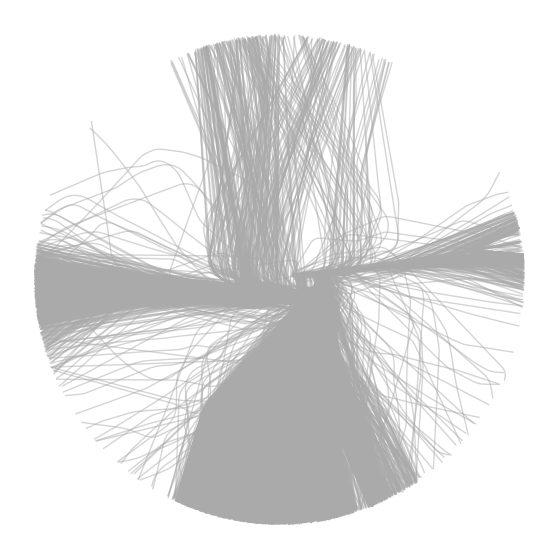

In [66]:
with plt.style.context("traffic"):
    ax = plt.axes(projection=Lambert93())
    t_to.plot(ax, alpha=0.5)
plt.show()

In [68]:
t_to = t_to.iterate_lazy().resample(200).eval(desc = "", max_workers = 20)
t_to.parquet.gz("../deep_traffic_generation/data/training_datasets/takeoffs_07.parquet.gz")

Output()